In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
sns.set(style = 'white', font_scale=1.3)

In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor import loadconceptor
from conceptor.tokenizer import CANCER_CODE, CONCEPT_palette, CONCEPT

CONCEPT_palette = pd.DataFrame([CONCEPT_palette]).T.reset_index().sort_index(ascending=False).set_index('index')[0].to_dict()

In [3]:
from explained_variance import explained_variance

In [4]:
data_path = '../../00_data/'
dfl = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, dfl.shape

dfcx = dfl.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)

In [5]:

model_path = '/home/was966/Research/mims-conceptor/paper/checkpoint/latest/pretrainer.pt'
pretrainer = loadconceptor(model_path)

dfg, dfc = pretrainer.extract(dfcx,  batch_size= 128)

100%|##########| 9/9 [00:03<00:00,  2.53it/s]


In [6]:
dfg.to_csv('01_pt_readouts_geneset.csv')
dfc.to_csv('02_pt_readouts_celltype.csv')

In [7]:

lin_order = {'Functional_group':4, 'Lymphoid_lineage_Bcell':0,
       'Lymphoid_lineage_T/NKcell':1, 'Mesenchymal_lineage':3,
       'Myeloid_lineage':2}

Lineage_map = CONCEPT.groupby(['Lineage', 'BroadCelltypePathway']).size().reset_index().set_index('BroadCelltypePathway').Lineage.to_dict()
Lineage_map.update({'CANCER':'Functional_group'})
concept_lin_order = pd.Series(Lineage_map).map(lin_order)

In [8]:
dfl.cohort = dfl.cancer_type + '_' +dfl.cohort

In [9]:
dfl.cancer_type.value_counts()

cancer_type
BLCA    408
SKCM    330
KIRC    198
LUAD    102
STAD     45
GBM      25
LUSC     25
Name: count, dtype: int64

In [10]:
def get_group(x):
    if x>100:
        return 'larger'
    else:
        if x<30:
            return 'small'
        else:
            return 'medium'

In [11]:
size_map = dfl.cohort.value_counts().apply(get_group)

In [12]:
alpha = 1e-6
# shift = (dfc.min().abs() + alpha)
# dfc = dfc + shift

dfc = (dfc - dfc.min()) / (dfc.max() - dfc.min())
dfc = dfc+alpha

In [13]:
from scipy.stats import mannwhitneyu, pointbiserialr

In [14]:
res = []
for cohort in dfl['cohort'].unique():
    sidx = dfl[dfl['cohort'] == cohort].index
    x = dfc.loc[sidx]
    y = dfl.loc[sidx].response_label
    group1 = x[y == 'NR']
    group2 = x[y == 'R']
    u_stat, p_value = mannwhitneyu(group1, group2)
    
    u = pd.Series(u_stat, index=x.columns)
    p = pd.Series(p_value, index=x.columns)
    fc1 = (group2.median() - group1.median())
    fc2 = (group2.median() / group1.median())
    gfc = np.log2(group2).median() - np.log2(group1).median()

    
    pbc = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[0], axis=0)
    pbc_p_value = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[1], axis=0)
    ev = x.apply(lambda x1:explained_variance(x1, y.map({'R':1, 'NR':0})), axis=0)

    df = pd.concat([u,p,fc1,fc2, gfc, pbc_p_value, pbc, ev], axis=1)
    df.columns = ['u_stat', 'p_value', 'fc_sub', 'fc_fold', 'gfc', 'pbc_p_value', 'pbc', 'ev']
    
    df['cohort'] = cohort
    res.append(df)


df1 = pd.concat(res)
df1.index.name = 'concept'
df1 = df1.reset_index()
df1['Lineage'] = df1.concept.map(Lineage_map)
df1['Lineage_order'] = df1.Lineage.map(lin_order)

In [15]:
res = []
for cohort in dfl['cancer_type'].unique():
    sidx = dfl[dfl['cancer_type'] == cohort].index
    x = dfc.loc[sidx]
    y = dfl.loc[sidx].response_label
    group1 = x[y == 'NR']
    group2 = x[y == 'R']
    u_stat, p_value = mannwhitneyu(group1, group2)
    
    u = pd.Series(u_stat, index=x.columns)
    p = pd.Series(p_value, index=x.columns)
    fc1 = (group2.median() - group1.median())
    fc2 = (group2.median() / group1.median())
    gfc = np.log2(group2).median() - np.log2(group1).median()

    
    pbc = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[0], axis=0)
    pbc_p_value = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[1], axis=0)
    ev = x.apply(lambda x1:explained_variance(x1, y.map({'R':1, 'NR':0})), axis=0)

    df = pd.concat([u,p,fc1,fc2, gfc, pbc_p_value, pbc, ev], axis=1)
    df.columns = ['u_stat', 'p_value', 'fc_sub', 'fc_fold', 'gfc', 'pbc_p_value', 'pbc', 'ev']
    
    df['cohort'] = cohort
    res.append(df)


df2 = pd.concat(res)
df2.index.name = 'concept'
df2 = df2.reset_index()
df2['Lineage'] = df2.concept.map(Lineage_map)
df2['Lineage_order'] = df2.Lineage.map(lin_order)

In [16]:
res = []
for cohort in ['All']:
    sidx = dfl.index
    x = dfc.loc[sidx]
    y = dfl.loc[sidx].response_label
    group1 = x[y == 'NR']
    group2 = x[y == 'R']
    u_stat, p_value = mannwhitneyu(group1, group2)
    
    u = pd.Series(u_stat, index=x.columns)
    p = pd.Series(p_value, index=x.columns)
    fc1 = (group2.median() - group1.median())
    fc2 = (group2.median() / group1.median())
    gfc = np.log2(group2).median() - np.log2(group1).median()

    
    pbc = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[0], axis=0)
    pbc_p_value = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[1], axis=0)
    ev = x.apply(lambda x1:explained_variance(x1, y.map({'R':1, 'NR':0})), axis=0)

    df = pd.concat([u,p,fc1,fc2, gfc, pbc_p_value, pbc, ev], axis=1)
    df.columns = ['u_stat', 'p_value', 'fc_sub', 'fc_fold', 'gfc', 'pbc_p_value', 'pbc', 'ev']
    
    df['cohort'] = cohort
    res.append(df)


df3 = pd.concat(res)
df3.index.name = 'concept'
df3 = df3.reset_index()
df3['Lineage'] = df3.concept.map(Lineage_map)
df3['Lineage_order'] = df3.Lineage.map(lin_order)

In [17]:
df = pd.concat([df1, df2, df3])
df.head()

,concept,u_stat,p_value,fc_sub,fc_fold,gfc,pbc_p_value,pbc,ev,cohort,Lineage,Lineage_order
0,CANCER,7644.5,0.779219,-1.788139e-07,1.000000,-2.579836e-07,0.947032,0.003865,0.000015,BLCA_IMVigor210,Functional_group,4
1,Bcell_general,8249.0,0.492451,-3.775644e-02,0.876744,-1.899207e-01,0.510037,-0.038309,0.001481,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
2,Memory_Bcell,8093.0,0.662460,-3.821900e-02,0.921612,-1.177735e-01,0.702629,-0.022206,0.000493,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
3,Naive_Bcell,7784.0,0.954651,3.614094e-03,1.060684,8.474612e-02,0.424325,-0.046452,0.002428,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
4,Plasma_cell,8273.0,0.468537,-1.795357e-02,0.963644,-5.342329e-02,0.396923,-0.049250,0.002440,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0


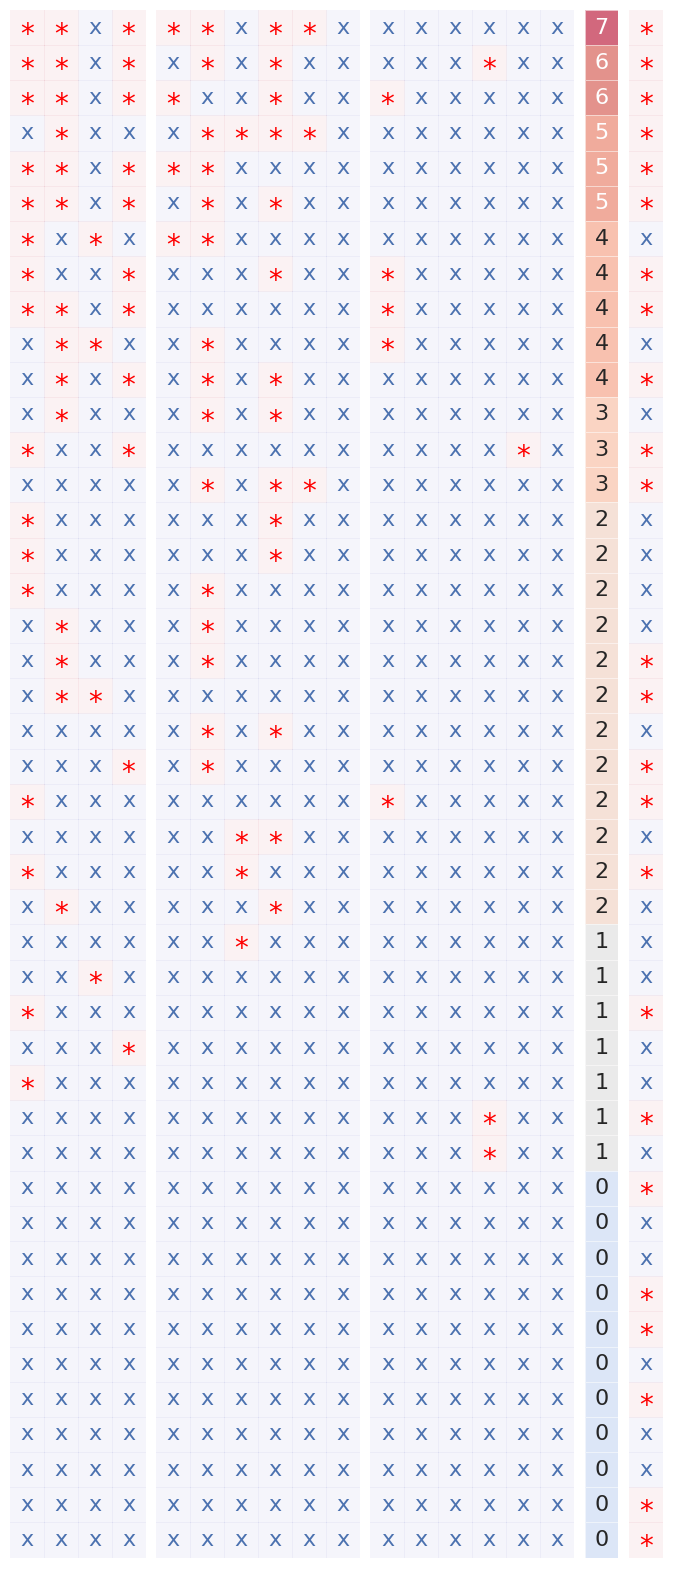

In [18]:
data = df.groupby(['cohort', 'concept']).apply(lambda x:(x['p_value'] < 0.05).sum()).reset_index()
data = pd.pivot_table(data, values = 0, columns = 'cohort', index = 'concept')

larger_group = size_map[size_map == 'larger'].index.tolist()
medium_group = size_map[size_map == 'medium'].index.tolist()
small_group = size_map[size_map == 'small'].index.tolist()
all_group = ['All']
cancer_group = ['BLCA', 'SKCM', 'KIRC', 'LUAD','STAD', 'GBM', 'LUSC']

sum = data[larger_group + medium_group + small_group].sum(axis=1).sort_values(ascending=False)
order = sum.index

# order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
# order.append('CANCER')

data = data.loc[order]
data['Sum'] = sum
sum_group = ['Sum']

groups = [larger_group, medium_group, small_group, sum_group, all_group]

fig, axes = plt.subplots(ncols=5, figsize = (7, 16), 
                         sharex=False, sharey=True, 
                         gridspec_kw={'width_ratios': [len(larger_group), len(medium_group), len(small_group), len(sum_group), len(all_group)]})

for group, ax in zip(groups, axes):

    data1 = data[group]

    if group != sum_group:
    # 使用seaborn绘制heatmap
        sns.heatmap(data1, annot=False, cmap='coolwarm', alpha = 0.05, cbar=False, linewidths=.5, ax=ax)
    
        # 在每个单元格中添加*或x
        for i in range(data1.shape[0]):
            for j in range(data1.shape[1]):
                symbol = '*' if data1.iloc[i, j] == 1 else 'x'
                color = 'red' if data1.iloc[i, j] == 1 else 'b'
                fontsize = 20 if data1.iloc[i, j] == 1 else 16
                y_offset = 0.2 if symbol == '*' else 0
                ax.text(j + 0.5, i + 0.5 + y_offset, symbol, ha='center', va='center', color=color, fontsize=fontsize)


    else:
        sns.heatmap(data1, annot=True, cmap='coolwarm', alpha = 0.6, cbar=False, linewidths=.5, ax=ax, vmin = -5, annot_kws=dict(fontsize = 16))

    # ax.set_xticklabels(group, rotation=90)
    # ax.set_ylabel(None)
    # ax.set_xlabel(None)
    # #ax.xaxis.tick_top()

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout(w_pad = 0.5)#
fig.savefig('./cohort_sig_to_response_ordered.svg',bbox_inches ='tight')
pd.Series(order).to_csv('cohort_sig_to_response_ordered.tsv',sep='\t')

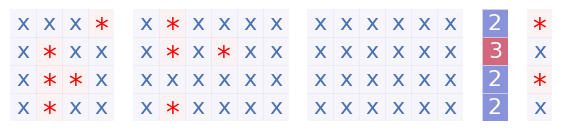

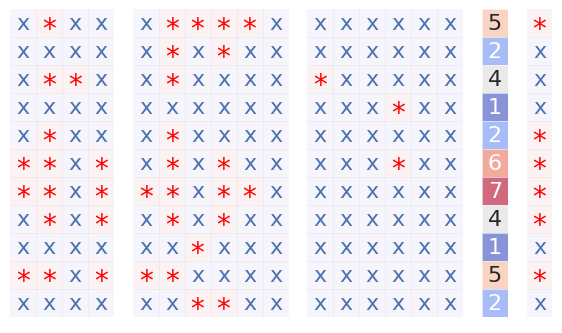

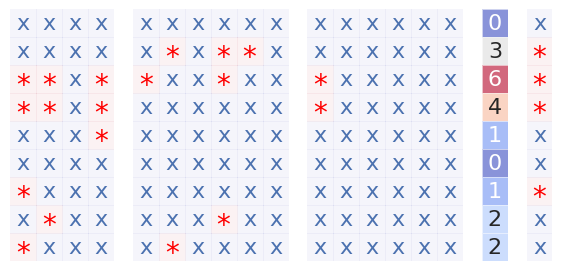

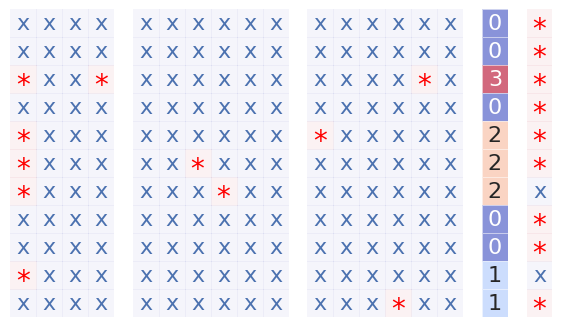

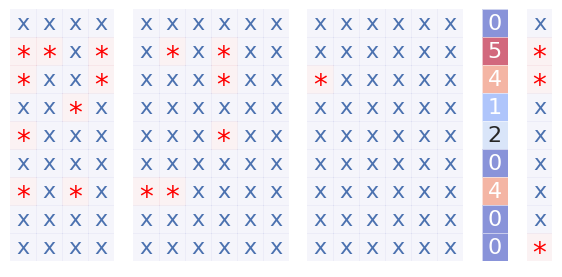

In [19]:
data = df.groupby(['cohort', 'concept']).apply(lambda x:(x['p_value'] < 0.05).sum()).reset_index()
data = pd.pivot_table(data, values = 0, columns = 'cohort', index = 'concept')

larger_group = size_map[size_map == 'larger'].index.tolist()
medium_group = size_map[size_map == 'medium'].index.tolist()
small_group = size_map[size_map == 'small'].index.tolist()
all_group = ['All']
cancer_group = ['BLCA', 'SKCM', 'KIRC', 'LUAD','STAD', 'GBM', 'LUSC']

sum = data[larger_group + medium_group + small_group].sum(axis=1).sort_values(ascending=False)
order = sum.index

order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
order.append('CANCER')

data = data.loc[order]
data['Sum'] = sum
sum_group = ['Sum']

groups = [larger_group, medium_group, small_group, sum_group, all_group]

lin = data.index.map(Lineage_map)

for l in ['Lymphoid_lineage_Bcell', 'Lymphoid_lineage_T/NKcell',
       'Myeloid_lineage', 'Mesenchymal_lineage', 'Functional_group']:

    myl = lin == l

    fig, axes = plt.subplots(ncols=5, figsize = (7, (16/44)*myl.sum()), 
                             sharex=False, sharey=True, 
                             gridspec_kw={'width_ratios': [len(larger_group), len(medium_group), len(small_group), len(sum_group), len(all_group)]})
    
    for group, ax in zip(groups, axes):
    
        data1 = data[group][myl]
    
        if group != sum_group:
        # 使用seaborn绘制heatmap
            sns.heatmap(data1, annot=False, cmap='coolwarm', alpha = 0.05, cbar=False, linewidths=.5, ax=ax)
        
            # 在每个单元格中添加*或x
            for i in range(data1.shape[0]):
                for j in range(data1.shape[1]):
                    symbol = '*' if data1.iloc[i, j] == 1 else 'x'
                    color = 'red' if data1.iloc[i, j] == 1 else 'b'
                    fontsize = 20 if data1.iloc[i, j] == 1 else 16
                    y_offset = 0.2 if symbol == '*' else 0
                    ax.text(j + 0.5, i + 0.5 + y_offset, symbol, ha='center', va='center', color=color, fontsize=fontsize)
    
    
        else:
            sns.heatmap(data1, annot=True, cmap='coolwarm', alpha = 0.6,   cbar=False, linewidths=.5, ax=ax, annot_kws=dict(fontsize = 16))
    
        # ax.set_xticklabels(group, rotation=90)
        # ax.set_ylabel(None)
        # ax.set_xlabel(None)
        #ax.xaxis.tick_top()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    #plt.tight_layout(w_pad = 0.5)#
    fig.savefig('./cohort_sig_to_response_%s.svg' % l.replace('/','_'), bbox_inches ='tight')


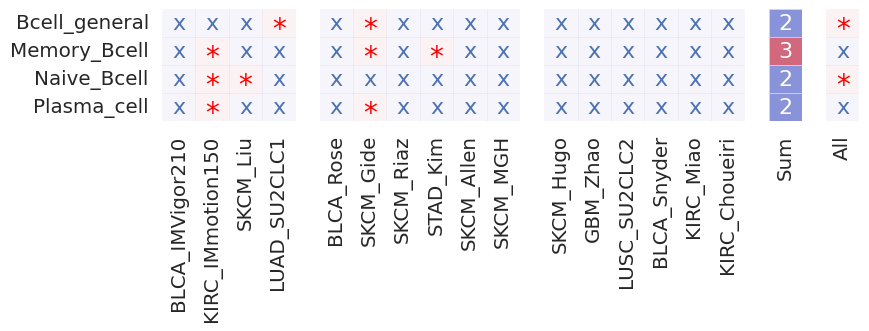

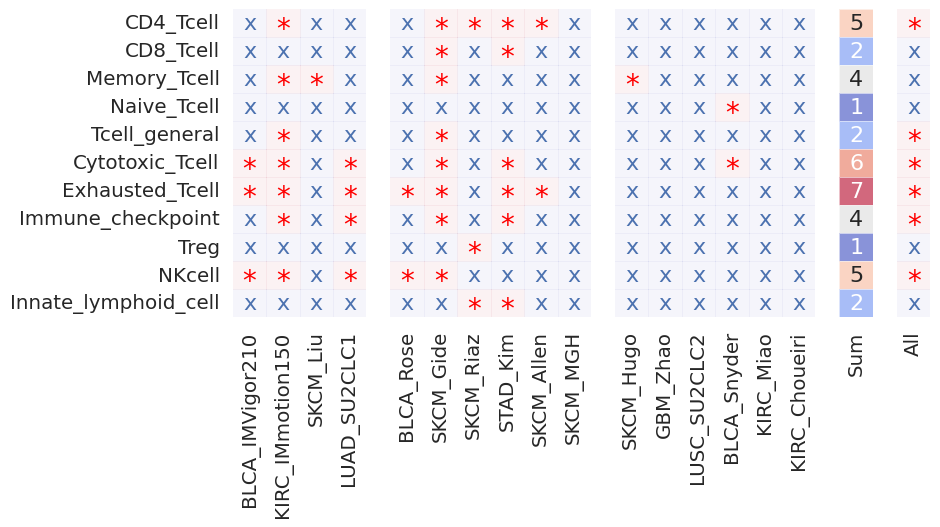

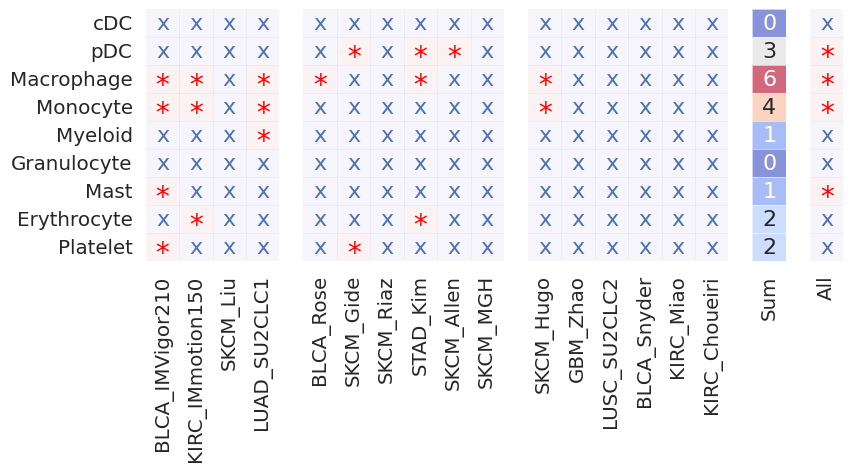

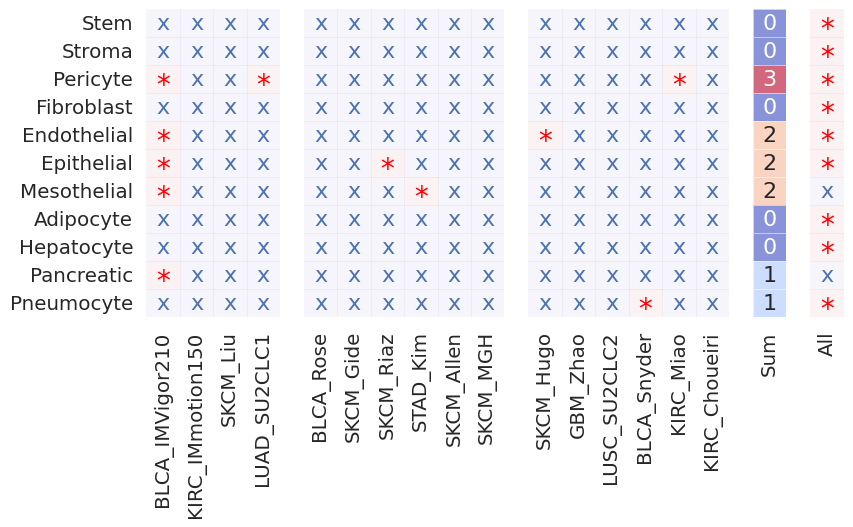

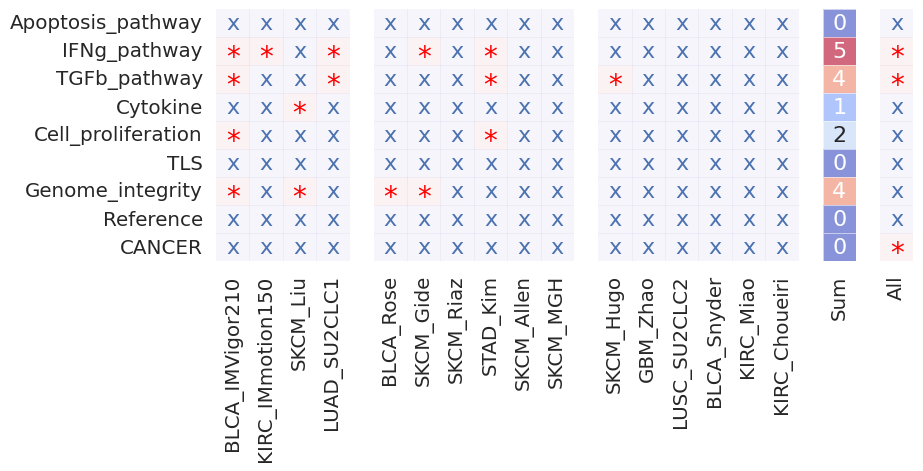

In [20]:
data = df.groupby(['cohort', 'concept']).apply(lambda x:(x['p_value'] < 0.05).sum()).reset_index()
data = pd.pivot_table(data, values = 0, columns = 'cohort', index = 'concept')

larger_group = size_map[size_map == 'larger'].index.tolist()
medium_group = size_map[size_map == 'medium'].index.tolist()
small_group = size_map[size_map == 'small'].index.tolist()
all_group = ['All']
cancer_group = ['BLCA', 'SKCM', 'KIRC', 'LUAD','STAD', 'GBM', 'LUSC']

sum = data[larger_group + medium_group + small_group].sum(axis=1).sort_values(ascending=False)
order = sum.index

order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
order.append('CANCER')

data = data.loc[order]
data['Sum'] = sum
sum_group = ['Sum']

groups = [larger_group, medium_group, small_group, sum_group, all_group]

lin = data.index.map(Lineage_map)

for l in ['Lymphoid_lineage_Bcell', 'Lymphoid_lineage_T/NKcell',
       'Myeloid_lineage', 'Mesenchymal_lineage', 'Functional_group']:

    myl = lin == l

    fig, axes = plt.subplots(ncols=5, figsize = (9, (16/44)*myl.sum()), 
                             sharex=False, sharey=True, 
                             gridspec_kw={'width_ratios': [len(larger_group), len(medium_group), len(small_group), len(sum_group), len(all_group)]})
    
    for group, ax in zip(groups, axes):
    
        data1 = data[group][myl]
    
        if group != sum_group:
        # 使用seaborn绘制heatmap
            sns.heatmap(data1, annot=False, cmap='coolwarm', alpha = 0.05, cbar=False, linewidths=.5, ax=ax)
        
            # 在每个单元格中添加*或x
            for i in range(data1.shape[0]):
                for j in range(data1.shape[1]):
                    symbol = '*' if data1.iloc[i, j] == 1 else 'x'
                    color = 'red' if data1.iloc[i, j] == 1 else 'b'
                    fontsize = 20 if data1.iloc[i, j] == 1 else 16
                    y_offset = 0.2 if symbol == '*' else 0
                    ax.text(j + 0.5, i + 0.5 + y_offset, symbol, ha='center', va='center', color=color, fontsize=fontsize)
    
    
        else:
            sns.heatmap(data1, annot=True, cmap='coolwarm', alpha = 0.6,   cbar=False, linewidths=.5, ax=ax, annot_kws=dict(fontsize = 16))
    
        ax.set_xticklabels(group, rotation=90)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        #ax.xaxis.tick_top()

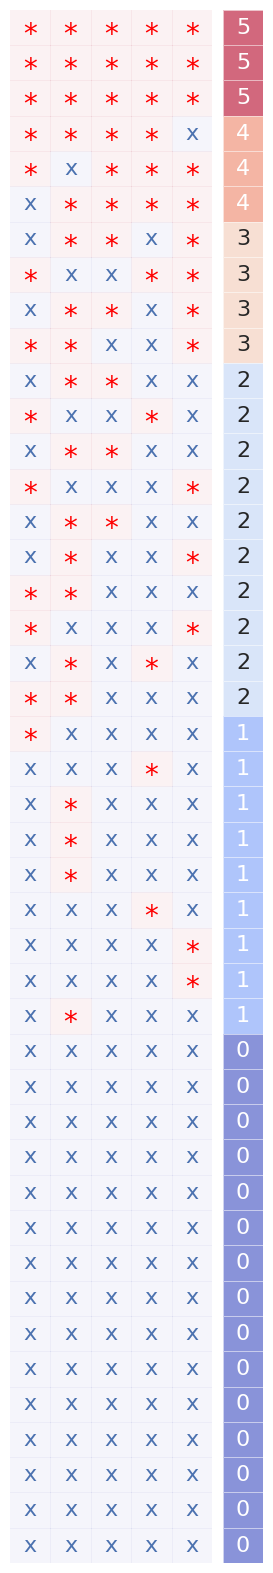

In [21]:
data = df.groupby(['cohort', 'concept']).apply(lambda x:(x['p_value'] < 0.05).sum()).reset_index()
data = pd.pivot_table(data, values = 0, columns = 'cohort', index = 'concept')

larger_group = size_map[size_map == 'larger'].index.tolist()
medium_group = size_map[size_map == 'medium'].index.tolist()
small_group = size_map[size_map == 'small'].index.tolist()
all_group = ['All']
cancer_group = ['BLCA', 'SKCM', 'KIRC', 'LUAD','STAD', ] #'GBM', 'LUSC'

sum = data[cancer_group].sum(axis=1).sort_values(ascending=False)
order = sum.index

# order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
# order.append('CANCER')

data = data.loc[order]
data['Sum'] = sum
sum_group = ['Sum']

fig, axes = plt.subplots(ncols=2, figsize = (6*0.5, 16), 
                         sharex=False, sharey=True, 
                         gridspec_kw={'width_ratios': [len(cancer_group), len(sum_group),]})

for group, ax in zip([cancer_group, sum_group, ], axes):

    data1 = data[group]

    if group != sum_group:
    # 使用seaborn绘制heatmap
        sns.heatmap(data1, annot=False, cmap='coolwarm', alpha = 0.05, cbar=False, linewidths=.5, ax=ax)
    
        # 在每个单元格中添加*或x
        for i in range(data1.shape[0]):
            for j in range(data1.shape[1]):
                symbol = '*' if data1.iloc[i, j] == 1 else 'x'
                color = 'red' if data1.iloc[i, j] == 1 else 'b'
                fontsize = 20 if data1.iloc[i, j] == 1 else 16
                y_offset = 0.2 if symbol == '*' else 0
                ax.text(j + 0.5, i + 0.5 + y_offset, symbol, ha='center', va='center', color=color, fontsize=fontsize)


    else:
        sns.heatmap(data1, annot=True, cmap='coolwarm', alpha = 0.6,   cbar=False, linewidths=.5, ax=ax, annot_kws=dict(fontsize = 16))

    ax.set_xticklabels(group, rotation=90)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    #ax.xaxis.tick_top()


    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.tight_layout(w_pad = 0.5)
fig.savefig('./cancer_sig_to_response.svg',bbox_inches ='tight')
pd.Series(order).to_csv('cancer_sig_to_response.tsv',sep='\t')

Text(236.25, 0.5, 'Cohort')

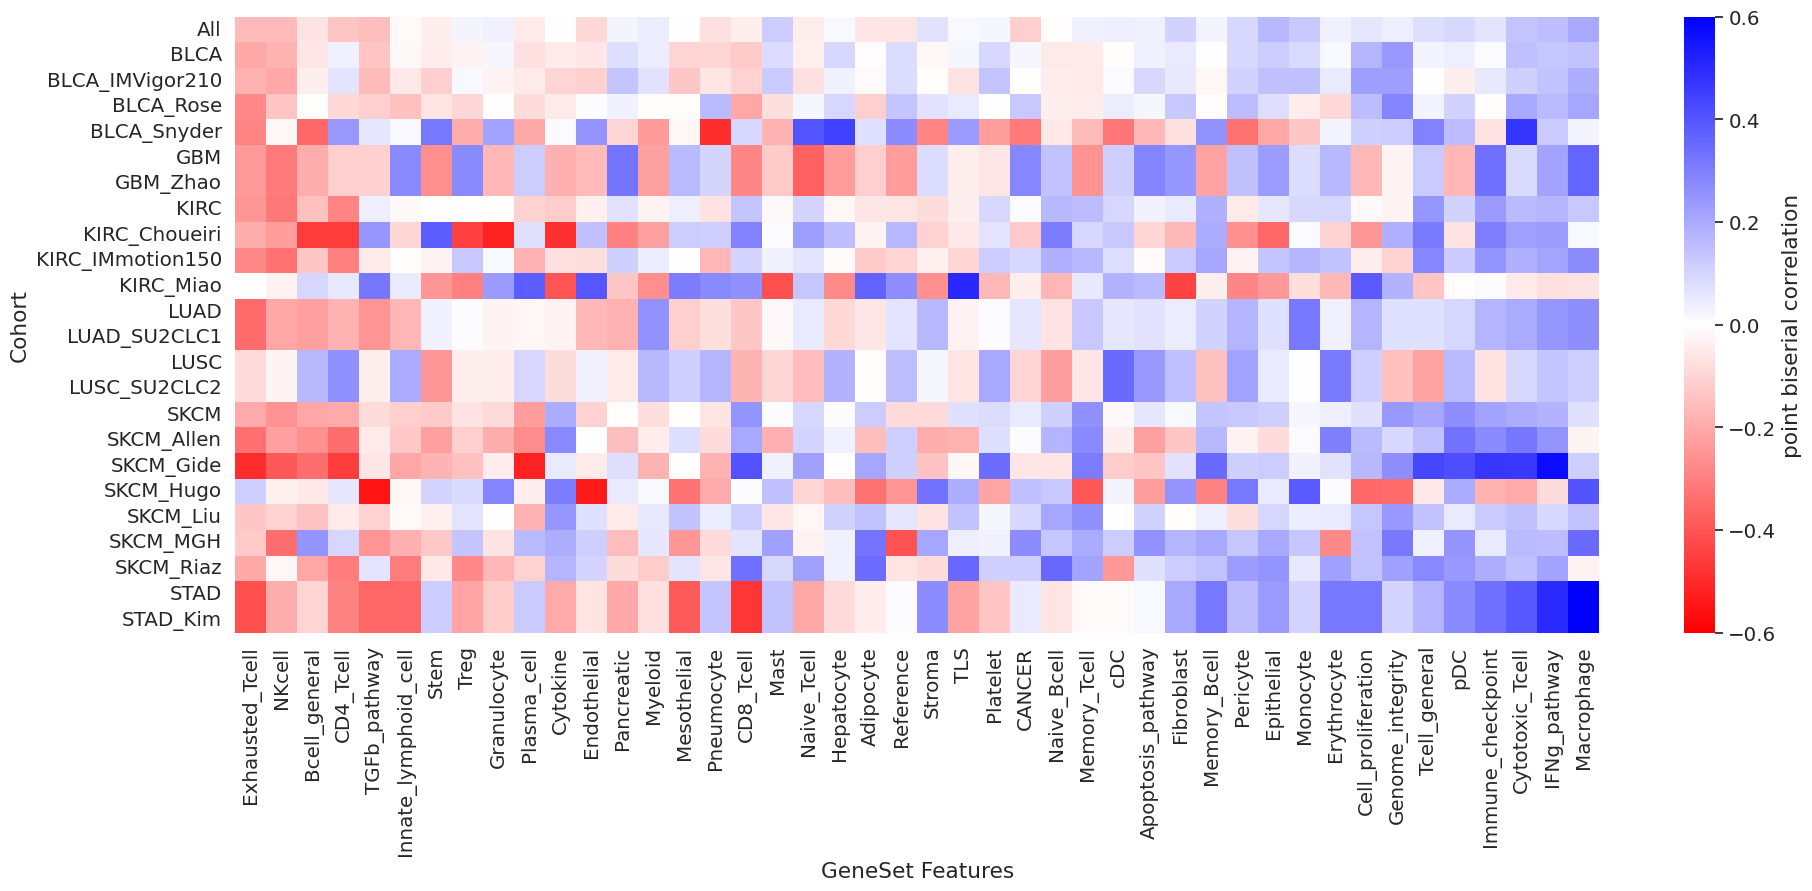

In [22]:
df_gfc = pd.pivot_table(df, columns='concept', index='cohort', values = 'pbc')
order = df_gfc.mean().sort_values().index
df_gfc = df_gfc[order]
fig, ax = plt.subplots(figsize = (22,8))
sns.heatmap(df_gfc, cmap = 'bwr_r', ax=ax, cbar_kws={'label': 'point biserial correlation'}, vmin = -0.6, vmax=0.6) # 

ax.set_xlabel('GeneSet Features')
ax.set_ylabel('Cohort')

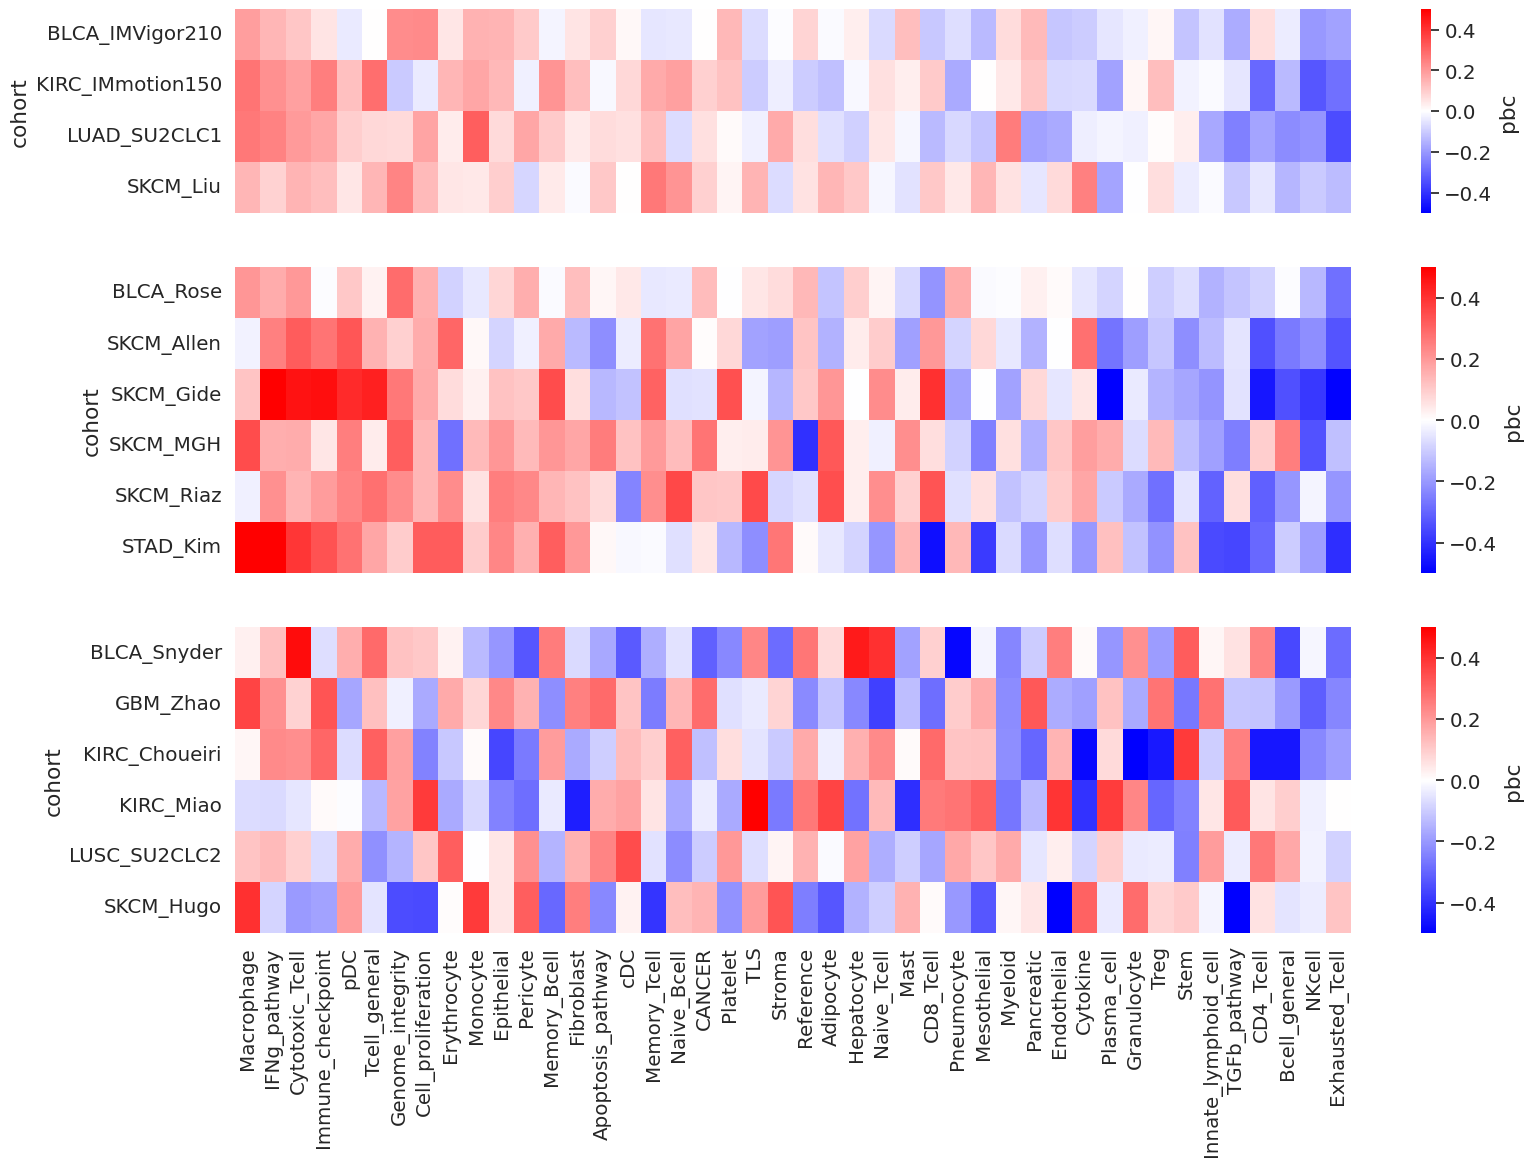

In [23]:
values = 'pbc'
df_gfc = pd.pivot_table(df, columns='concept', index='cohort', values = values)
order = df_gfc.mean().sort_values(ascending=False).index
df_gfc = df_gfc[order]

fig, axes = plt.subplots(nrows=3, figsize = (18,0.5*len(df_gfc)), sharex=True, gridspec_kw={'height_ratios': [4, 6, 6]})

ax1, ax2, ax3 = axes


scohort = size_map[size_map=='larger'].index
dfp = df_gfc[df_gfc.index.isin(scohort)]
sns.heatmap(dfp, cmap = 'bwr', ax=ax1, cbar_kws={'label': values}, vmin = -0.5, vmax=0.5) # 


scohort = size_map[size_map=='medium'].index
dfp = df_gfc[df_gfc.index.isin(scohort)]
sns.heatmap(dfp, cmap = 'bwr', ax=ax2, cbar_kws={'label': values}, vmin = -0.5, vmax=0.5) # 


scohort = size_map[size_map=='small'].index
dfp = df_gfc[df_gfc.index.isin(scohort)]
sns.heatmap(dfp, cmap = 'bwr', ax=ax3, cbar_kws={'label': values}, vmin = -0.5, vmax=0.5) # 


for ax in axes:
    ax.set_xlabel('')


In [24]:
cancer_group

['BLCA', 'SKCM', 'KIRC', 'LUAD', 'STAD']

### pbc bar large cohort

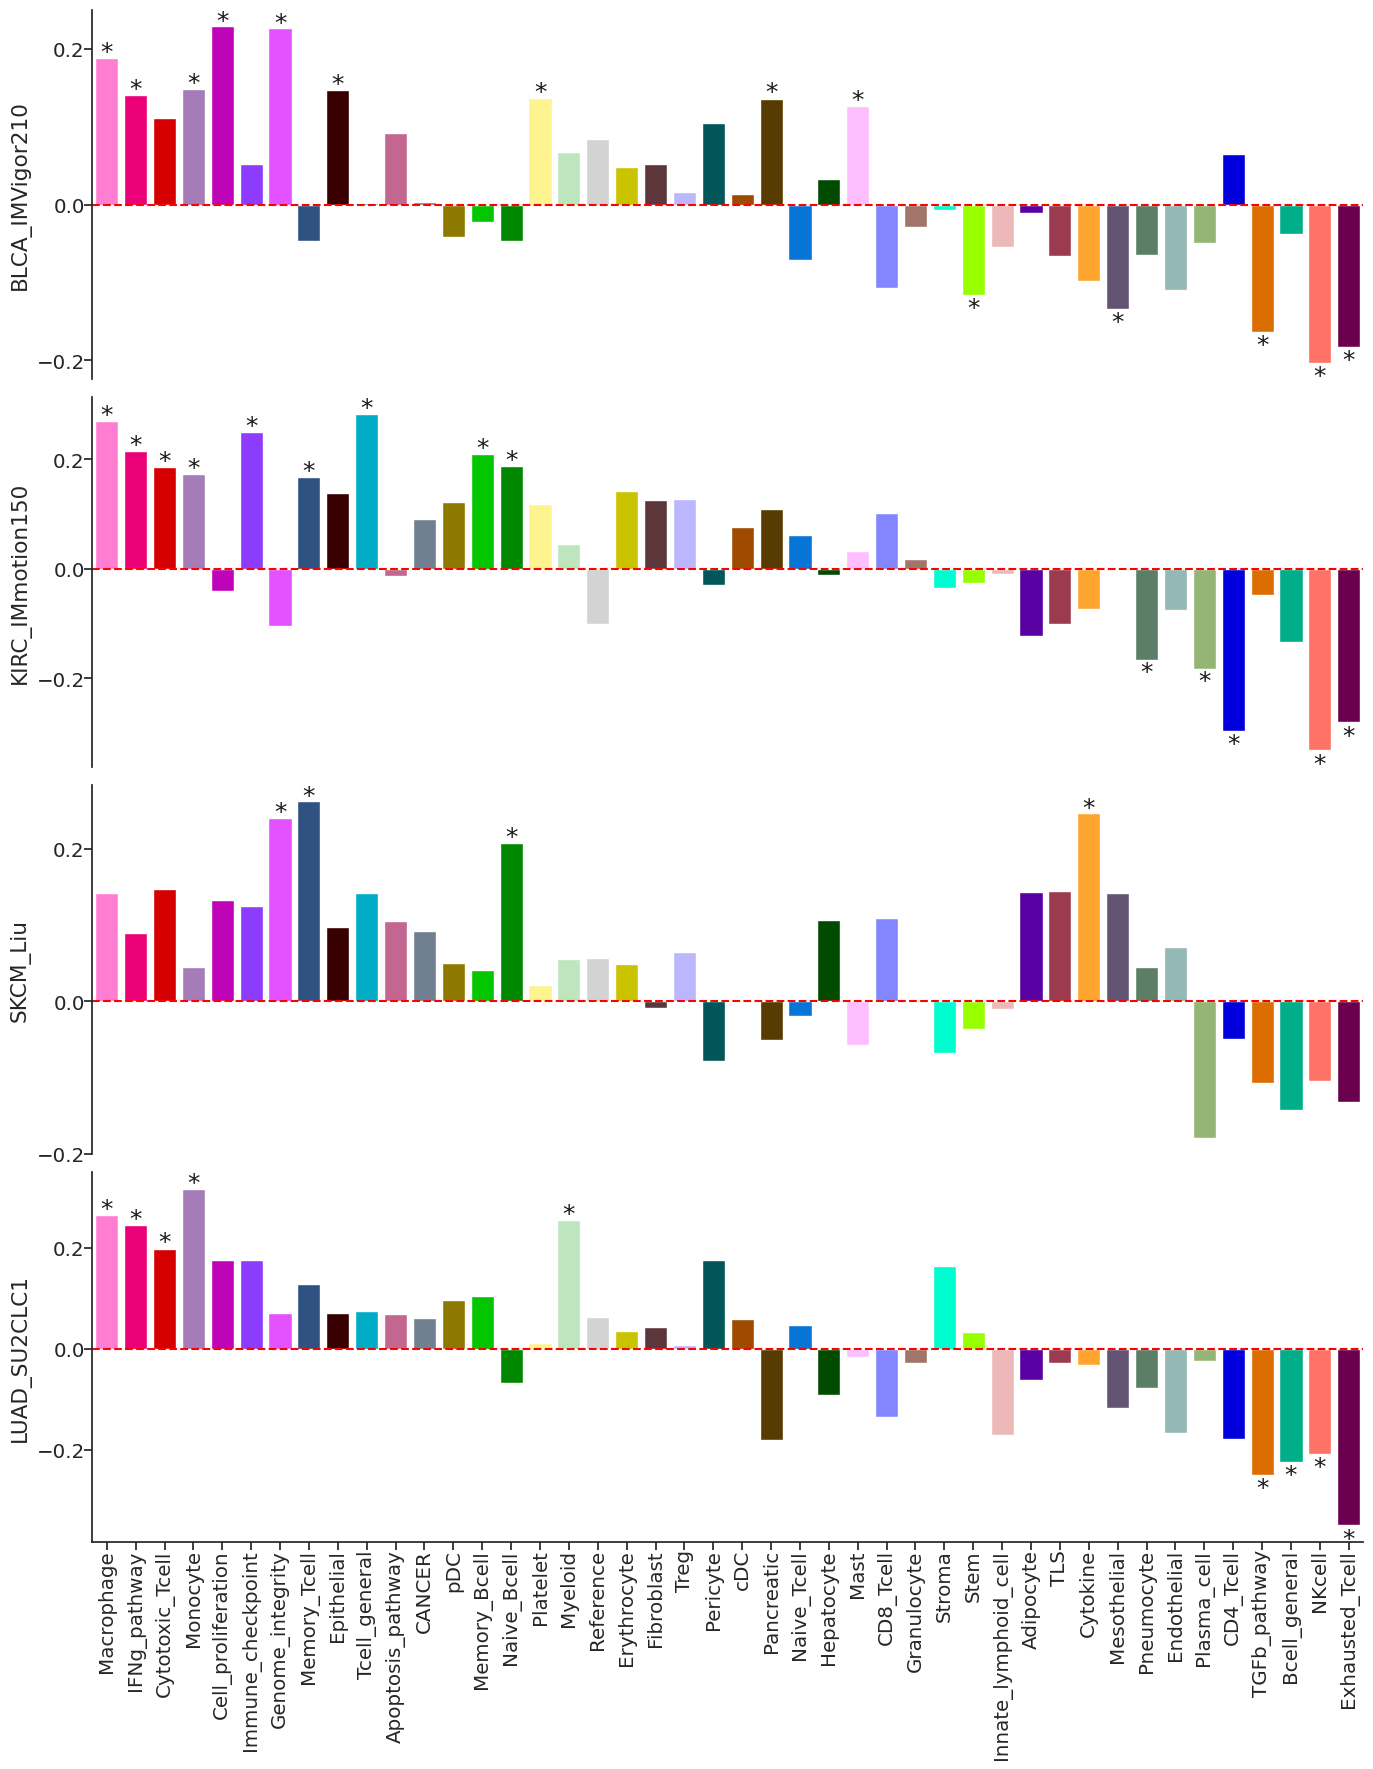

In [25]:
fc = 'pbc'
p = 'pbc_p_value'

df1 = df[[fc, p, 'concept', 'cohort', 'Lineage_order']]


scohort = size_map[size_map=='larger'].index
df1 = df1[df1.cohort.isin(scohort)]


order = df1.groupby('concept')[fc].median().sort_values(ascending=False).index


# order_df = df1.groupby('concept')[fc].mean().to_frame(name = 'mean')
# order_df['l_order'] = -order_df.index.map(concept_lin_order)
# order = order_df.sort_values(['l_order', 'mean'], ascending=False).index

# order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
# order.append('CANCER')

# 定义特征颜色
feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.5), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        # ax.set_xticklabels([])
        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
        #ax.set_ylim(-abs(cohort_data[fc].min())+0.1, cohort_data[fc].max()-0.02)
    # 调整布局

plt.tight_layout(h_pad=0.1)
plt.show()

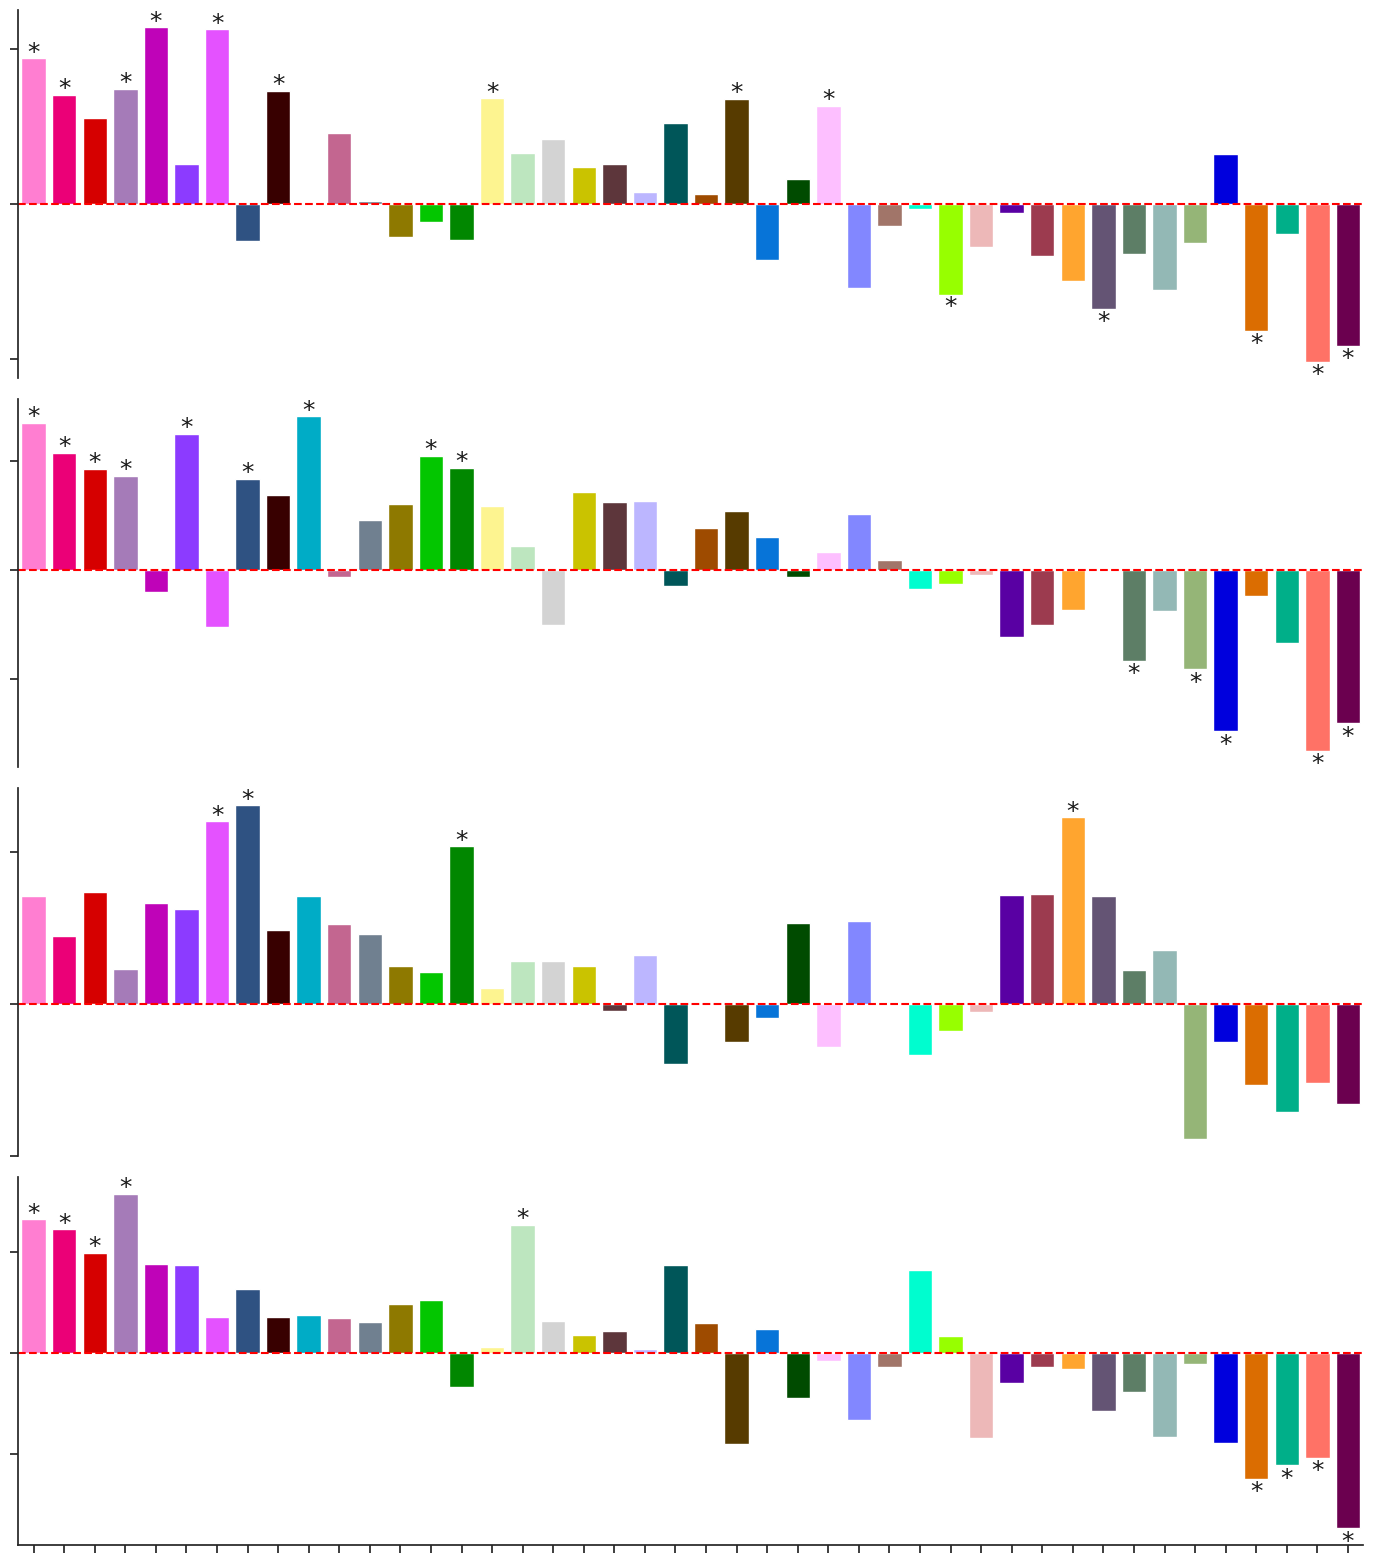

In [26]:
fc = 'pbc'
p = 'pbc_p_value'

df1 = df[[fc, p, 'concept', 'cohort', 'Lineage_order']]


scohort = size_map[size_map=='larger'].index
df1 = df1[df1.cohort.isin(scohort)]


order = df1.groupby('concept')[fc].median().sort_values(ascending=False).index


# order_df = df1.groupby('concept')[fc].mean().to_frame(name = 'mean')
# order_df['l_order'] = -order_df.index.map(concept_lin_order)
# order = order_df.sort_values(['l_order', 'mean'], ascending=False).index

# order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
# order.append('CANCER')

# 定义特征颜色
feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel(None)


plt.tight_layout(h_pad=0.1)
fig.savefig('./pbc_bar_large_cohort.svg',bbox_inches ='tight')
pd.Series(index=order).to_csv('pbc_bar_large_cohort_order.tsv',sep='\t')

### pbc bar medium/small cohort

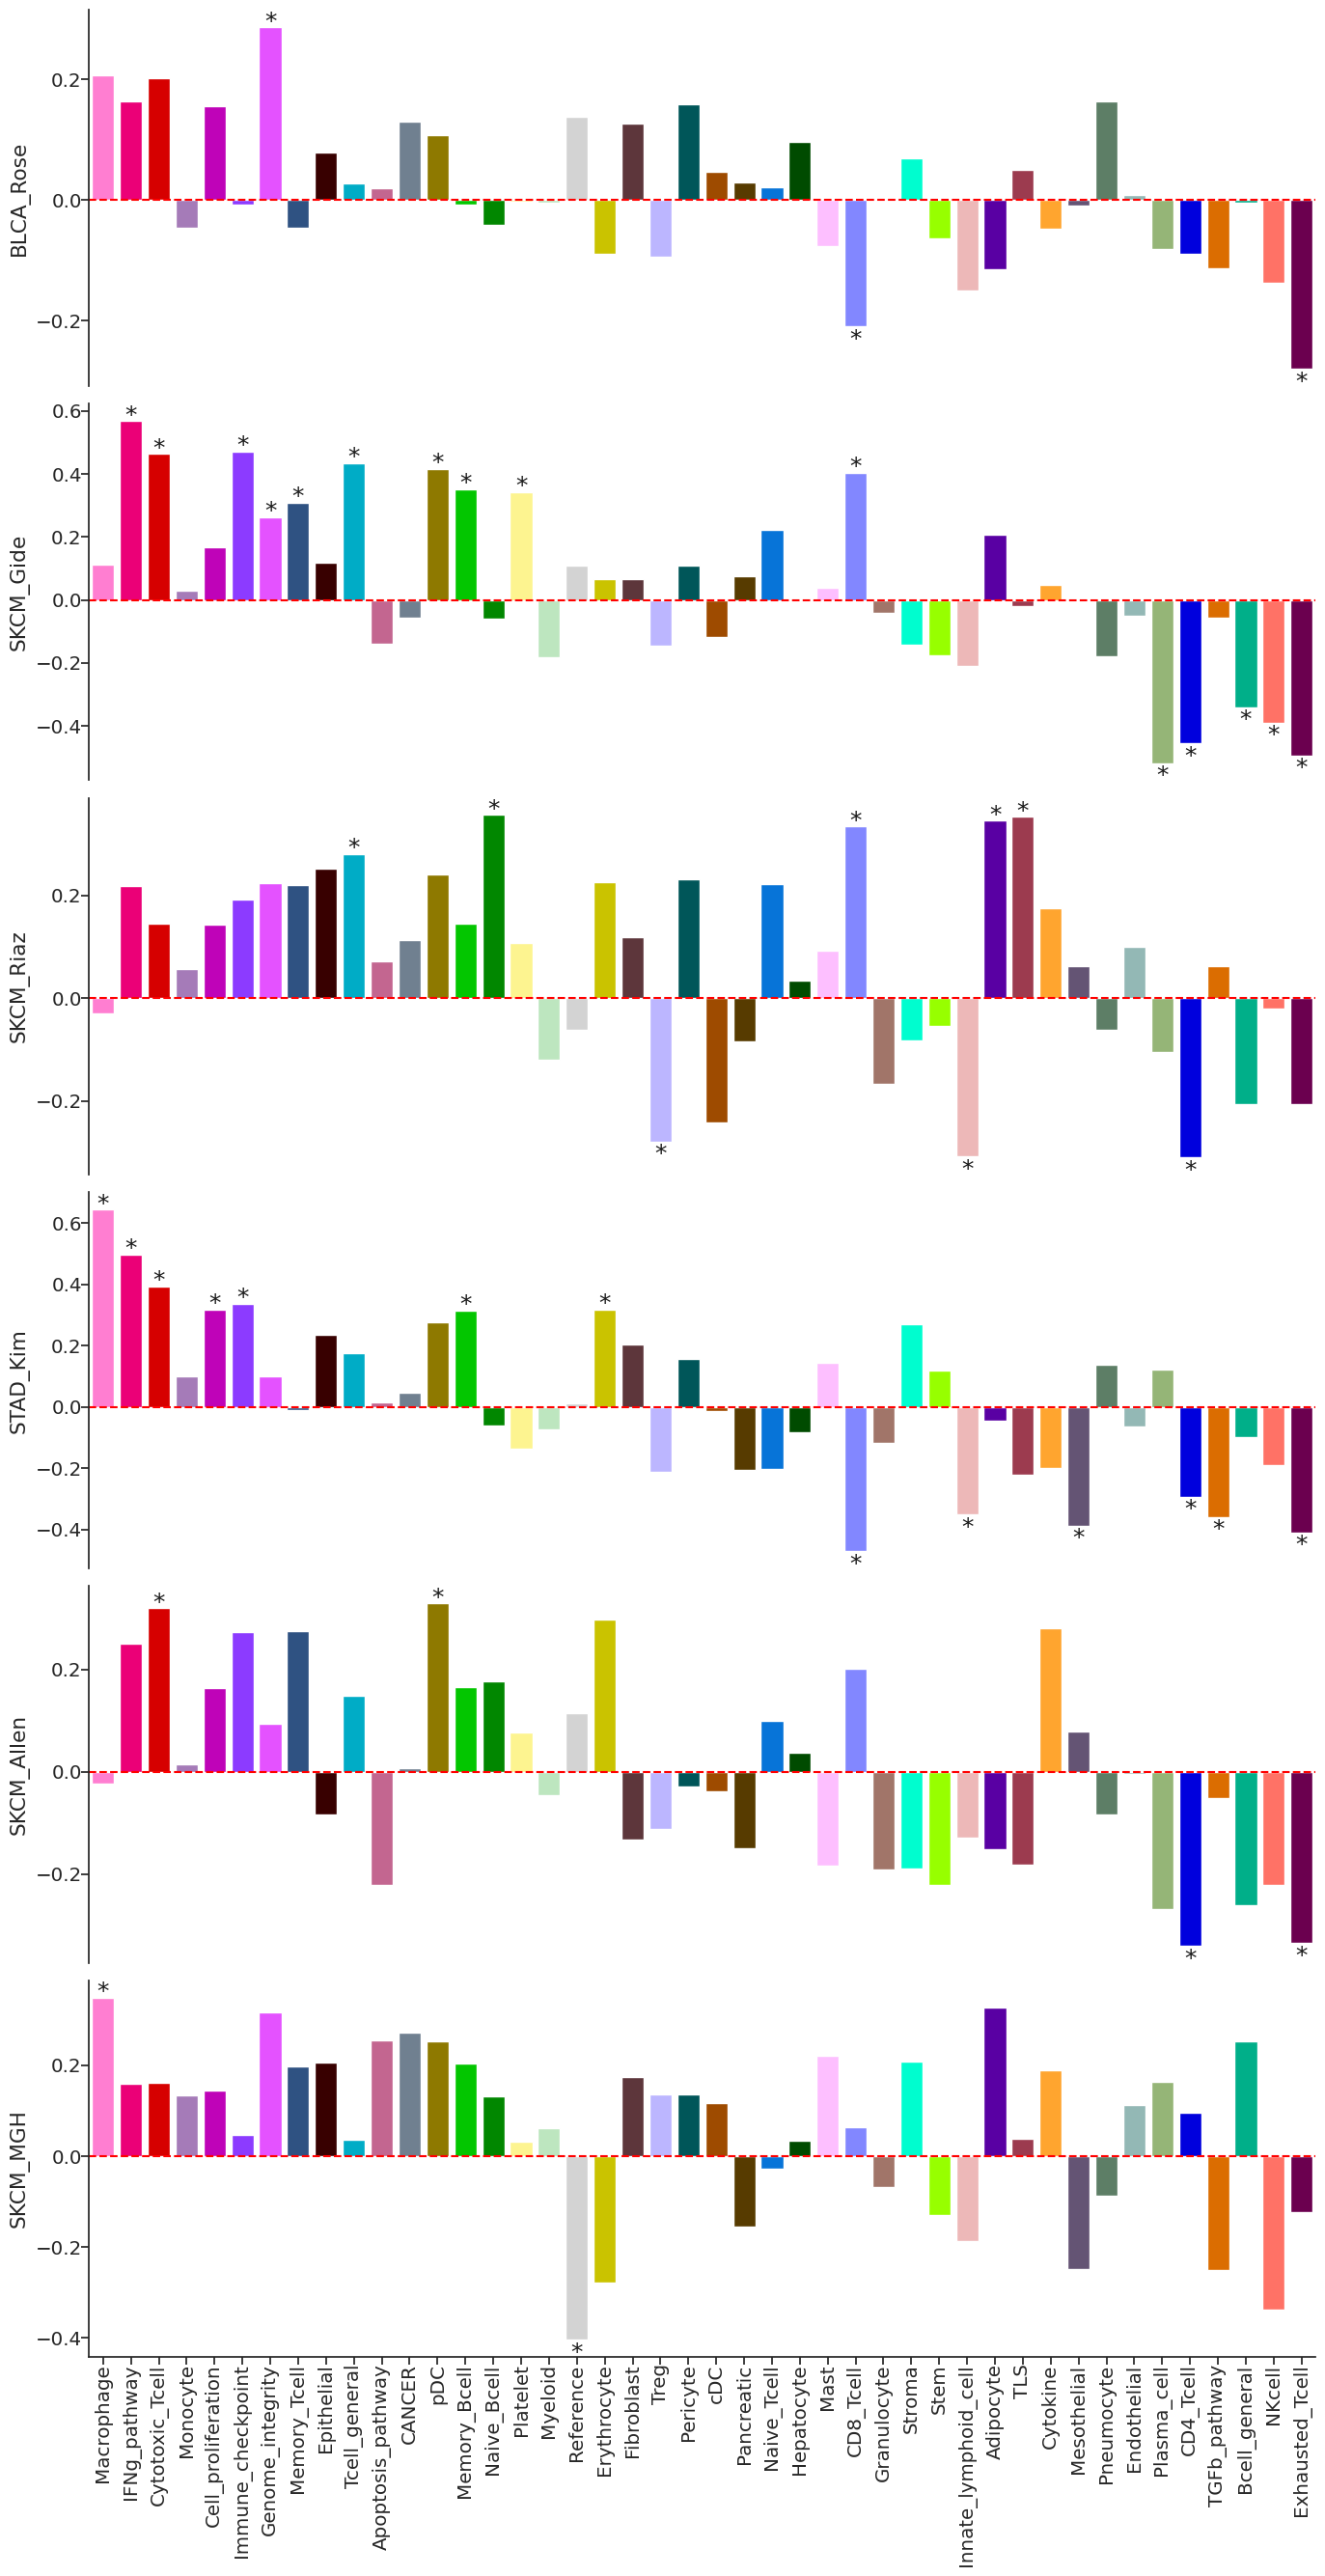

In [27]:
scohort = size_map[size_map=='medium'].index
df1 = df[df.cohort.isin(scohort)]

feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.5), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        # ax.set_xticklabels([])
        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
        #ax.set_ylim(-abs(cohort_data[fc].min())+0.1, cohort_data[fc].max()-0.02)
    # 调整布局

plt.tight_layout(h_pad=0.1)
fig.savefig('./pbc_bar_medium_cohort.svg',bbox_inches ='tight')

In [28]:
scohort

Index(['BLCA_Rose', 'SKCM_Gide', 'SKCM_Riaz', 'STAD_Kim', 'SKCM_Allen',
       'SKCM_MGH'],
      dtype='object', name='cohort')

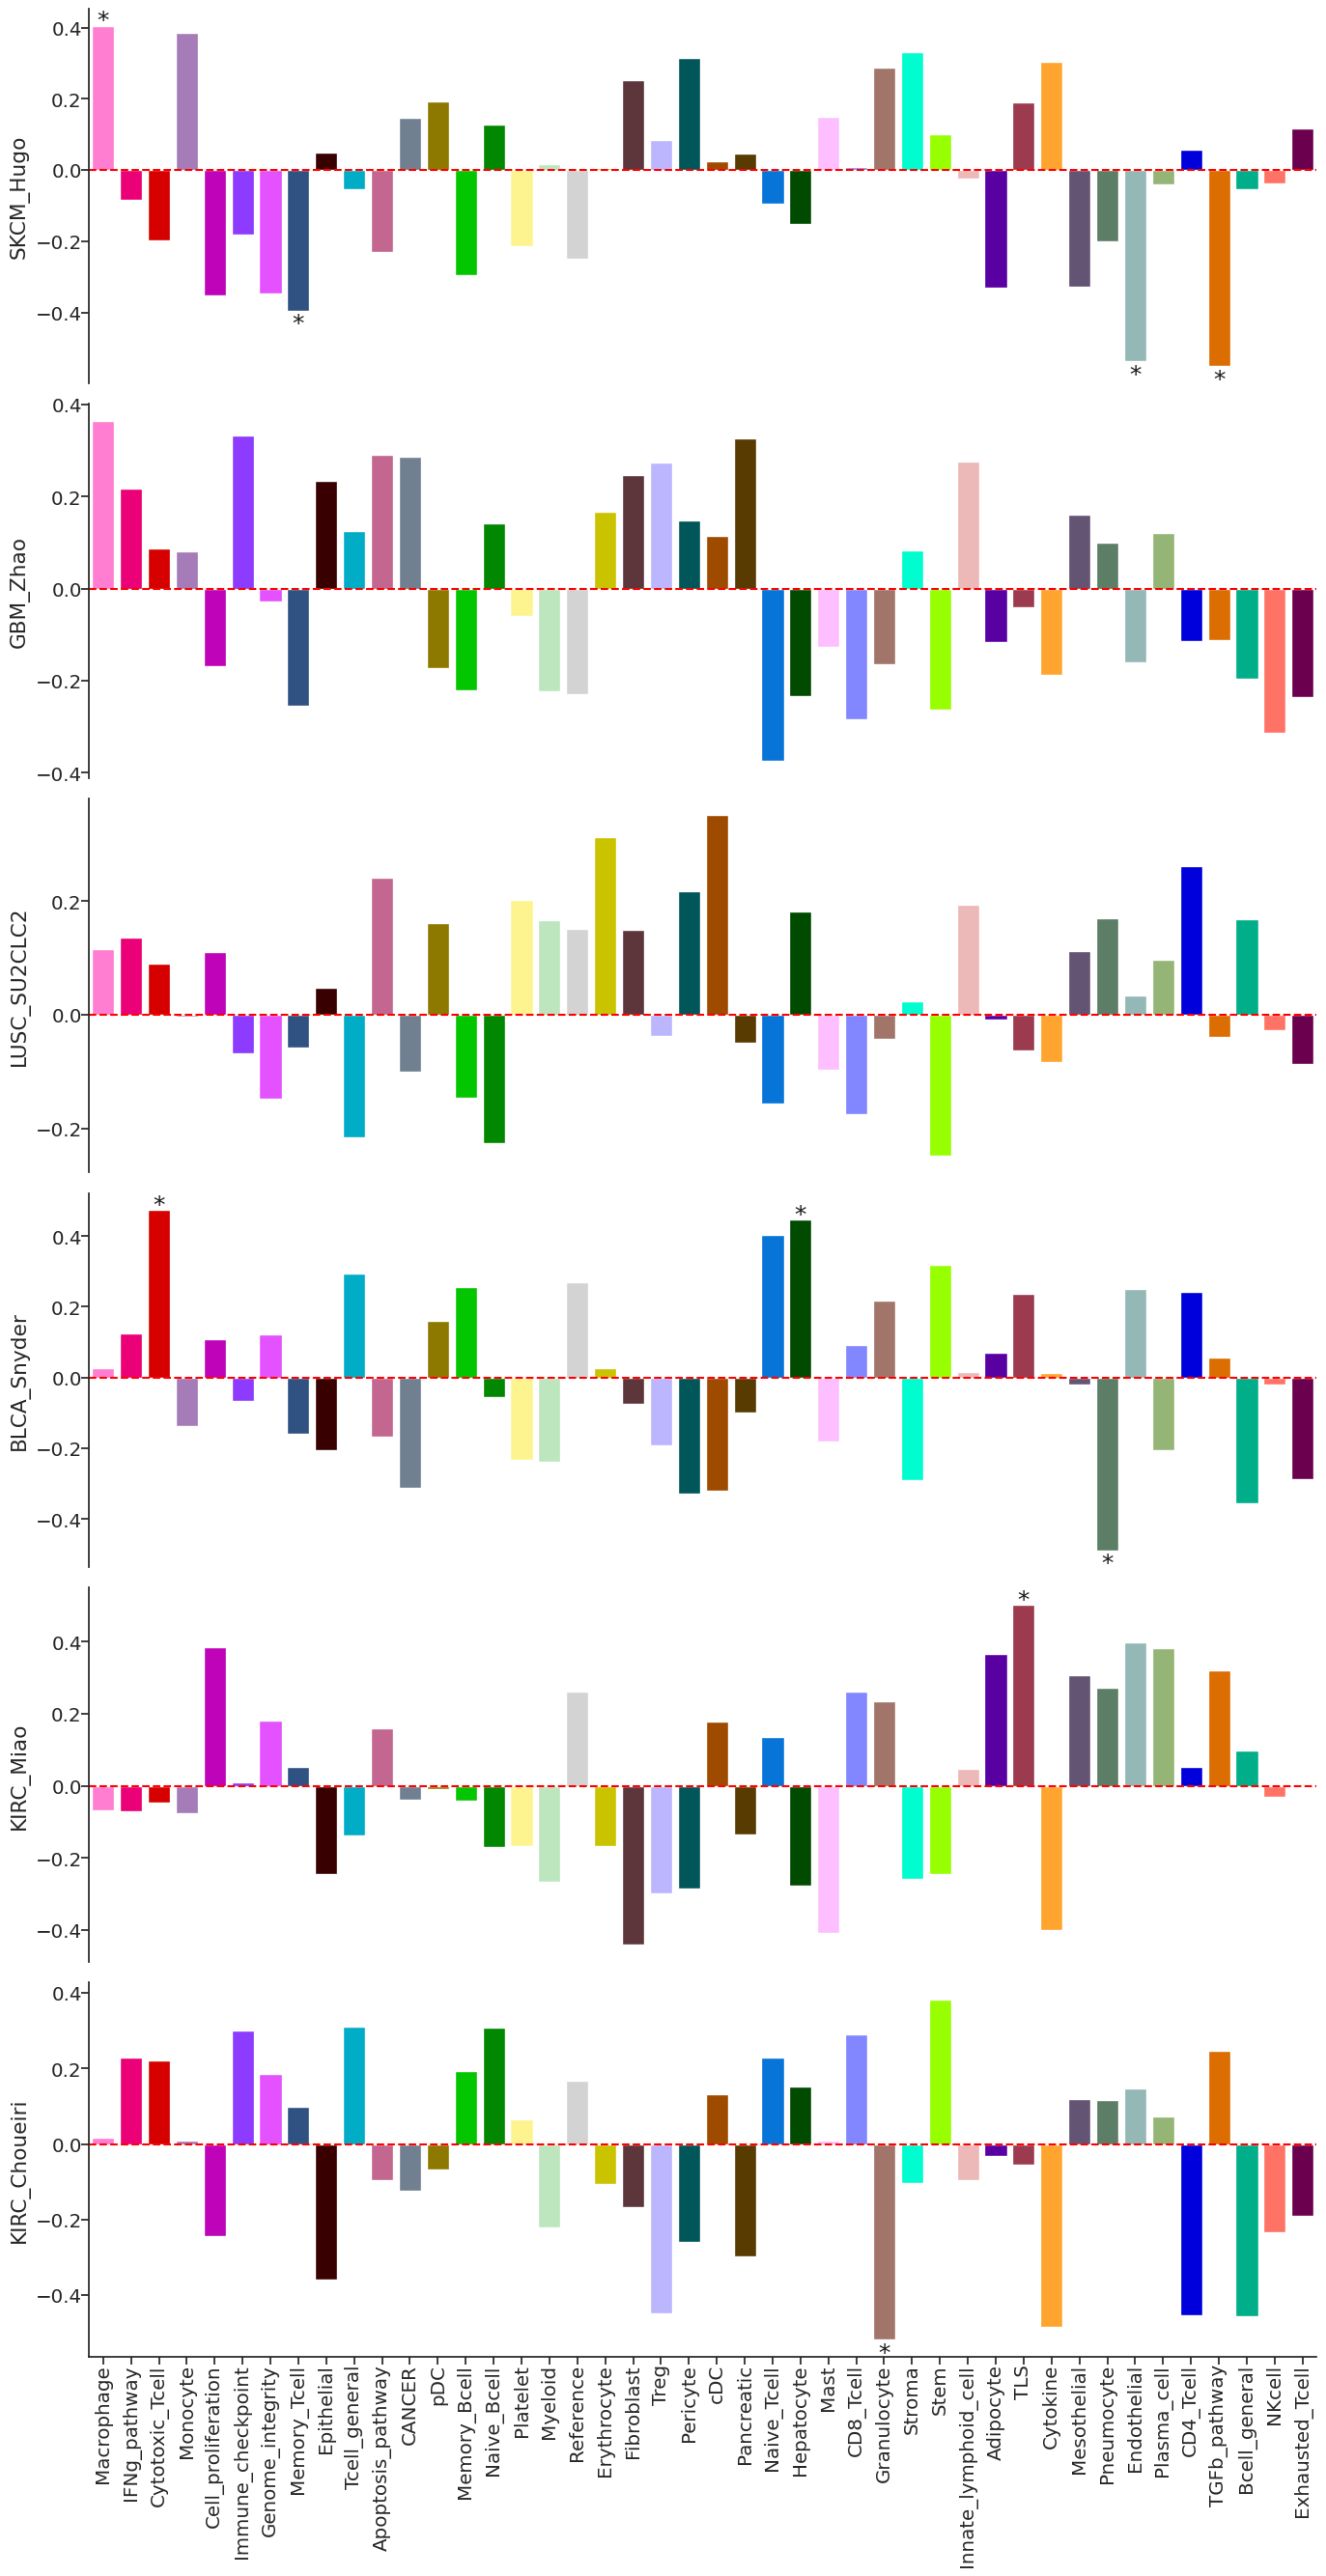

In [29]:
scohort = size_map[size_map=='small'].index
df1 = df[df.cohort.isin(scohort)]

feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.5), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        # ax.set_xticklabels([])
        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
        #ax.set_ylim(-abs(cohort_data[fc].min())+0.1, cohort_data[fc].max()-0.02)
    # 调整布局

plt.tight_layout(h_pad=0.1)
fig.savefig('./pbc_bar_small_cohort.svg',bbox_inches ='tight')

In [30]:
df

,concept,u_stat,p_value,fc_sub,fc_fold,gfc,pbc_p_value,pbc,ev,cohort,Lineage,Lineage_order
0,CANCER,7644.5,0.779219,-1.788139e-07,1.000000,-2.579836e-07,0.947032,0.003865,1.493054e-05,BLCA_IMVigor210,Functional_group,4
1,Bcell_general,8249.0,0.492451,-3.775644e-02,0.876744,-1.899207e-01,0.510037,-0.038309,1.480774e-03,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
2,Memory_Bcell,8093.0,0.662460,-3.821900e-02,0.921612,-1.177735e-01,0.702629,-0.022206,4.925591e-04,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
3,Naive_Bcell,7784.0,0.954651,3.614094e-03,1.060684,8.474612e-02,0.424325,-0.046452,2.428456e-03,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
4,Plasma_cell,8273.0,0.468537,-1.795357e-02,0.963644,-5.342329e-02,0.396923,-0.049250,2.439665e-03,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
...,...,...,...,...,...,...,...,...,...,...,...,...
39,Cytokine,133164.0,0.556038,7.748455e-03,1.020261,2.893865e-02,0.984150,0.000591,3.490332e-07,All,Functional_group,4
40,Cell_proliferation,128079.0,0.111574,1.161028e-02,1.046469,6.552947e-02,0.050819,0.058036,3.331071e-03,All,Functional_group,4
41,TLS,128020.0,0.108982,1.436865e-02,1.043539,6.148350e-02,0.549278,0.017809,3.152346e-04,All,Functional_group,4
42,Genome_integrity,127182.5,0.077080,2.684867e-02,1.057039,8.002841e-02,0.176572,0.040176,1.621825e-03,All,Functional_group,4


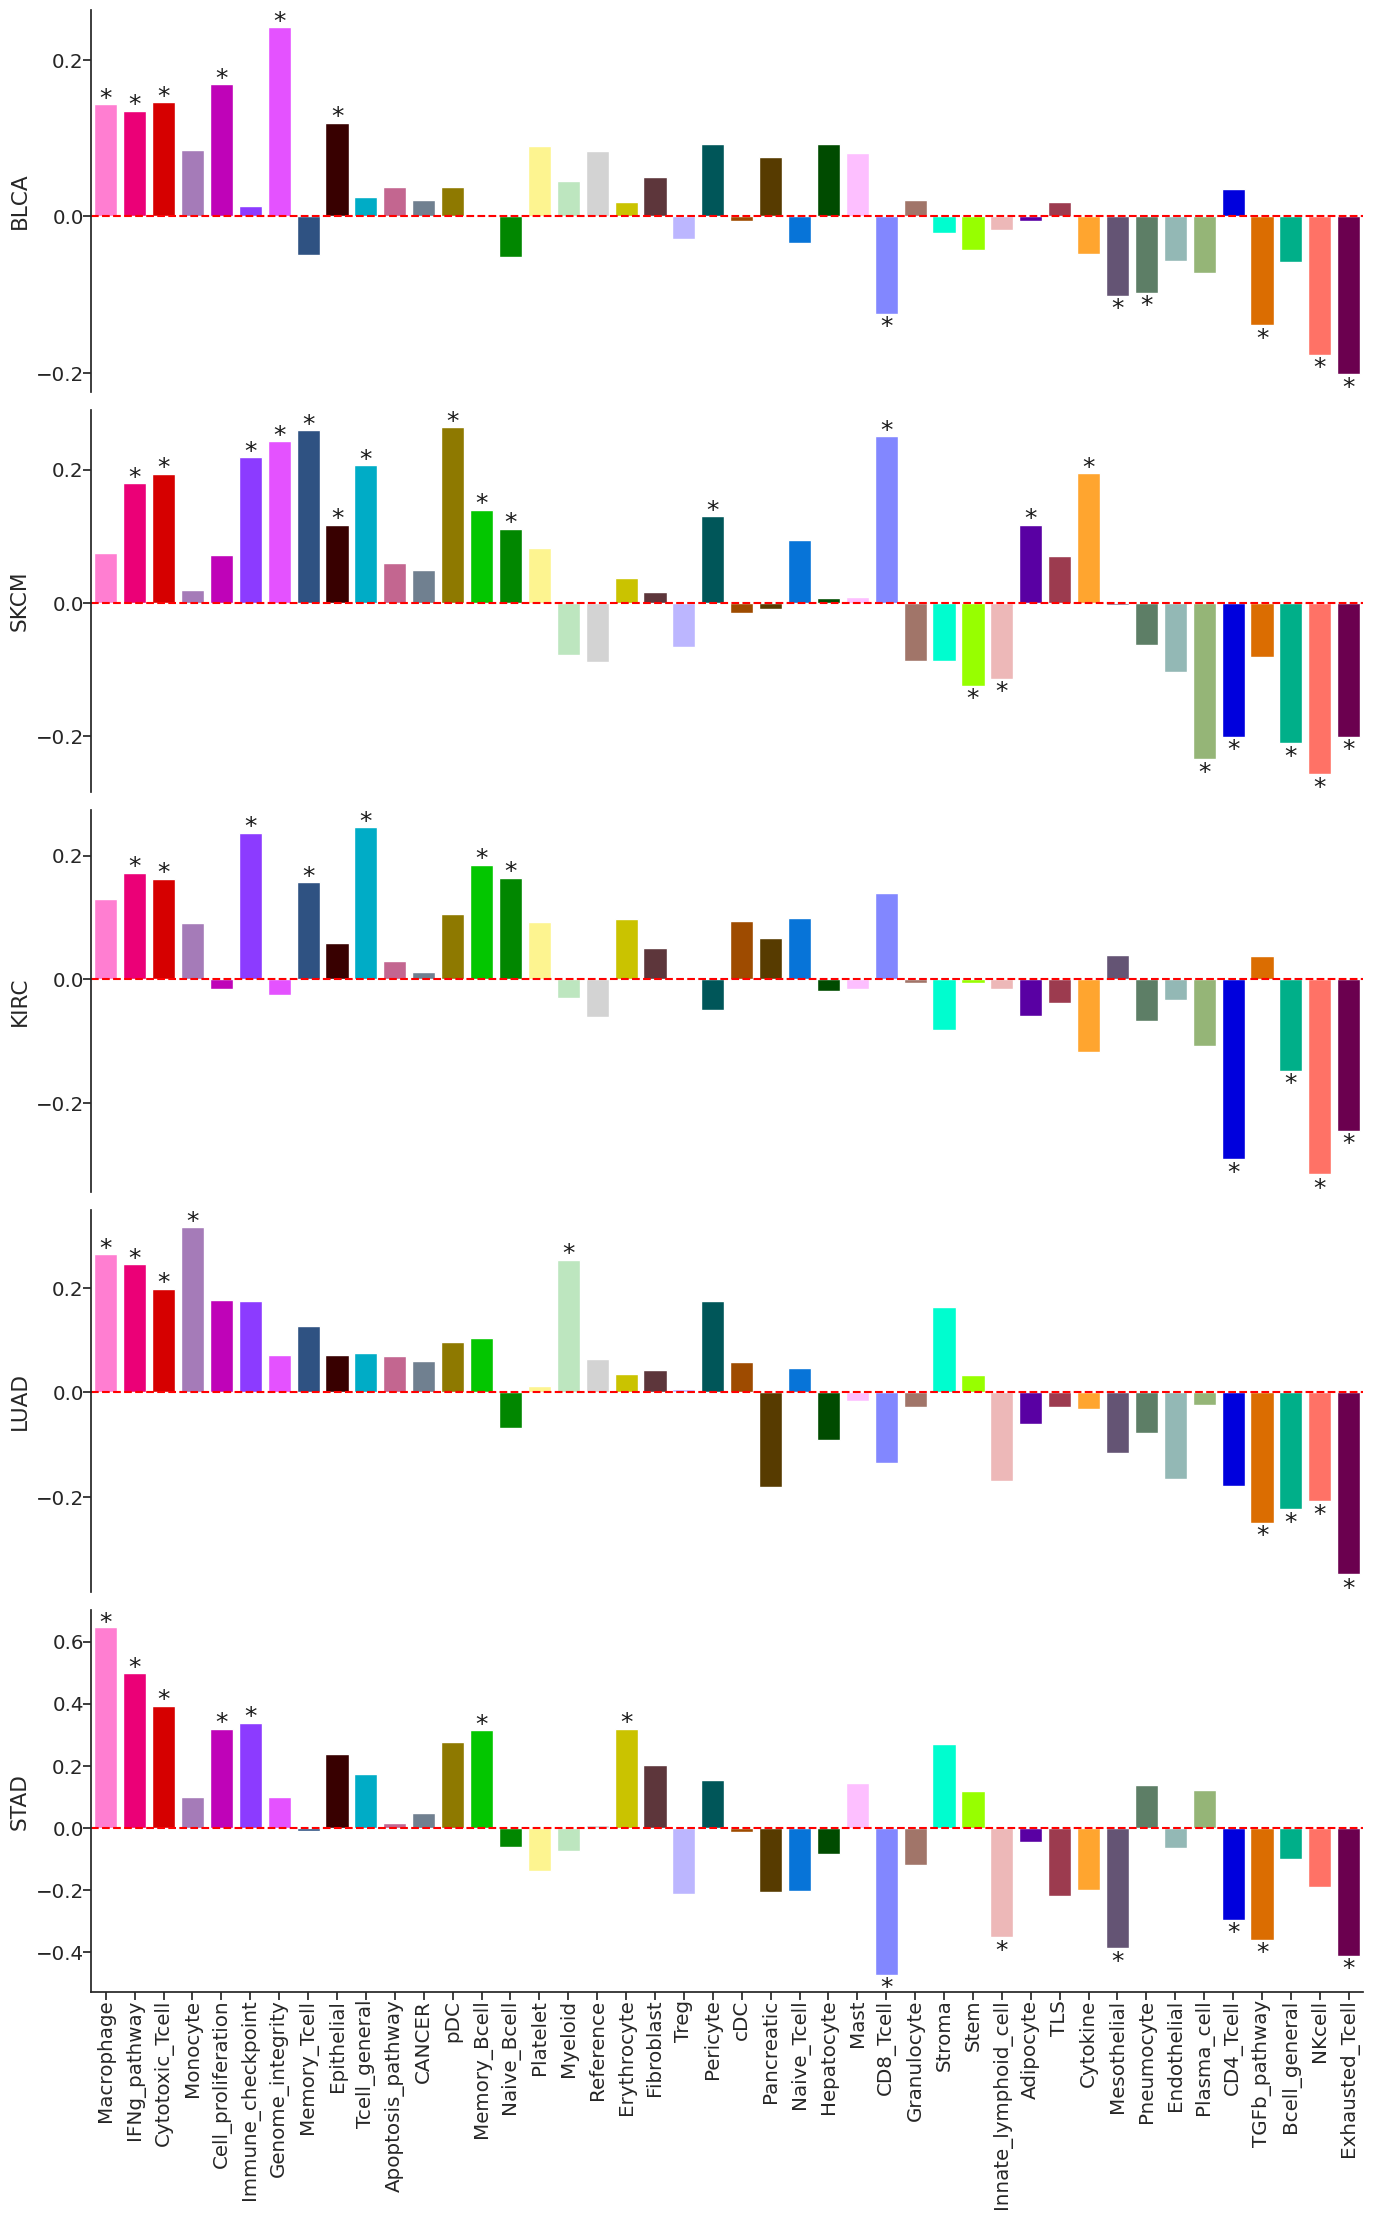

In [31]:
scohort = cancer_group
df1 = df[df.cohort.isin(scohort)]

feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.5), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        # ax.set_xticklabels([])
        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
        #ax.set_ylim(-abs(cohort_data[fc].min())+0.1, cohort_data[fc].max()-0.02)
    # 调整布局

plt.tight_layout(h_pad=0.1)
fig.savefig('./pbc_bar_cancer_group.svg',bbox_inches ='tight')